# Info

My idea was to use a ResNet18 to learn the images, once I achieve a good accuracy on that, I change the last layer from 27 output units to 512, to generate image encodings. I then 1 hot encode the categorical features. And lastly, use the Tensorflow Universal Sentence Encoder to encode the text descriptions. Concatenating all of these together, to get a 1086 feature vector. I then train 3 MLPs independently, using proper cross validation technique given from https://www.kaggle.com/eliotbarr/stacking-test-sklearn-xgboost-catboost-lightgbm?fbclid=IwAR00lg7rllxP4StErSB_FgC4nJtsFQQBoU69mpSH-_twyfx_qW5i1efb7do, of each which I take the probabilities and pass into logistic regression (27+27+27) -> 27. This performed really well. Using a single MLP also worked great. They worked on my validation sets. I also tried using XGBoost decision trees, and they performed very well as well. However, I ran into some bugs regarding order of my encodings which I was unable to solve, and was not able to submit any of my additions (Stacked MLPs, Encoded features to 1 MLP, XGBClassifier) because there was an ordering issue or something. Thus my submission on Kaggle is a simple Resnet. I really really hope I can achieve some part marks for all the extra work I have done. I also ran into Usage limits with Colab and had to use 3 gmail accounts.

# import/dict init

In [ ]:
import torch as t, torch.nn as nn, torch.nn.functional as tnnF
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
import torchvision as tv, torchvision.transforms as tr
from torchvision import models
from collections import Counter
import matplotlib.pyplot as plt
from torch.autograd import Variable
from PIL import Image
import pdb
import csv
import pandas as pd
import os
import sys
import numpy as np

In [ ]:
im_sz = 96

In [ ]:
genders_dict = {'Boys': 0, 'Girls': 1, 'Men': 2, 'Unisex': 3, 'Women': 4}
baseColours_dict = {'Beige': 0, 'Black': 1, 'Blue': 2, 'Bronze': 3, 'Brown': 4, 'Burgundy': 5, 'Charcoal': 6, 'Coffee Brown': 7, 'Copper': 8, 'Cream': 9, 'Fluorescent Green': 10, 'Gold': 11, 'Green': 12, 'Grey': 13, 'Grey Melange': 14, 'Khaki': 15, 'Lavender': 16, 'Lime Green': 17, 'Magenta': 18, 'Maroon': 19, 'Mauve': 20, 'Metallic': 21, 'Multi': 22, 'Mushroom Brown': 23, 'Mustard': 24, 'Navy Blue': 25, 'Nude': 26, 'Off White': 27, 'Olive': 28, 'Orange': 29, 'Peach': 30, 'Pink': 31, 'Purple': 32, 'Red': 33, 'Rose': 34, 'Rust': 35, 'Sea Green': 36, 'Silver': 37, 'Skin': 38, 'Steel': 39, 'Tan': 40, 'Taupe': 41, 'Teal': 42, 'Turquoise Blue': 43, 'White': 44, 'Yellow': 45}
seasons_dict = {'Fall': 0, 'Spring': 1, 'Summer': 2, 'Winter': 3}
usages_dict = {'Casual': 0, 'Ethnic': 1, 'Formal': 2, 'Party': 3, 'Smart Casual': 4, 'Sports': 5, 'Travel': 6}
categories_dict = {'Accessories': 0, 'Apparel Set': 1, 'Bags': 2, 'Belts': 3, 'Bottomwear': 4, 'Cufflinks': 5, 'Dress': 6, 'Eyewear': 7, 'Flip Flops': 8, 'Fragrance': 9, 'Free Gifts': 10, 'Headwear': 11, 'Innerwear': 12, 'Jewellery': 13, 'Lips': 14, 'Loungewear and Nightwear': 15, 'Makeup': 16, 'Nails': 17, 'Sandal': 18, 'Saree': 19, 'Scarves': 20, 'Shoes': 21, 'Socks': 22, 'Ties': 23, 'Topwear': 24, 'Wallets': 25, 'Watches': 26}

# Image Encoder (resnet)

In [ ]:
n_classes = 27
seed = 1
t.manual_seed(seed)
if t.cuda.is_available(): t.cuda.manual_seed_all(seed)
device = t.device('cuda' if t.cuda.is_available() else 'cpu')

In [ ]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                            #####                         
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]   ########                                
    return weight   

def evaluate(f,data,device):
    f.eval()
    losses,accs = [],[]
    for x,y in data:
        x,y = x.to(device),y.to(device)
        logits = f(x)
        loss = nn.CrossEntropyLoss()(logits,y)
        acc = (logits.max(1)[1] == y).float().mean()
        losses.append(loss.item())
        accs.append(acc.item())
    f.train()
    return np.mean(losses),np.mean(accs)

def load_data(path_train):
    RGB_MEAN = [0.8235, 0.8086, 0.8016]
    RGB_STD = [0.2145, 0.2261, 0.2292]
    fn = tr.Compose([tr.Pad(4,padding_mode='reflect'),
                    #tr.Resize(im_sz),
                    #tr.CenterCrop(im_sz),
                    #tr.GaussianBlur(5,1),
                    #tr.Grayscale(),
                    tr.ToTensor(),#,
                    tr.RandomHorizontalFlip()])
                    #tr.Normalize(mean=RGB_MEAN,std=RGB_STD)])
    #dset = tv.datasets.ImageFolder(root='/content/drive/MyDrive/CS480/Final/train',transform=fn)
    dset = tv.datasets.ImageFolder(root=path_train,transform=fn)
    lbls = [dset[i][1].item() for i in range(len(dset))]
    cnts = Counter(lbls)
    test_ctrs = [int(0.1*v) for v in cnts.values()] # then try [5]*27
    train_inds,test_inds = [],[]
    for i,(x,y) in enumerate(dset):
        if test_ctrs[y] > 0:
            test_inds.append(i)
            test_ctrs[y] -= 1
        else:
            train_inds.append(i)

    dset_train = Subset(dset,train_inds)
    imgs = [d[0] for d in dset_train]
    dset_test = Subset(dset,test_inds)

    weights = make_weights_for_balanced_classes(dset_train,n_classes)
    weights = t.DoubleTensor(weights)
    sampler = t.utils.data.sampler.WeightedRandomSampler(weights,len(weights))

    dload_train = DataLoader(dset_train,sampler=sampler,batch_size=32,num_workers=4,drop_last=True)
    dload_test = DataLoader(dset_test,batch_size=32,num_workers=4,drop_last=True)

    return dload_train,dload_test

class F(nn.Module):
    def __init__(self,model_arch="resnet18",n_classes=27):
        super(F,self).__init__()
        if model_arch == "resnet18":
            self.model = models.resnet18(pretrained=True)
            self.num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(self.num_ftrs,n_classes)
        if model_arch == "resnet34":
            self.model = models.resnet34()#pretrained=True)
            self.num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(self.num_ftrs,n_classes)

    def forward(self,x):
        logits = self.model(x)
        return logits

def load_model(device,arch="resnet18",path=None):
    if path is not None:
        print("loading model from ",path)
        ckpt_dict = t.load(path)
        f = F(arch,n_classes)
        f.load_state_dict(ckpt_dict['model_state_dict'])
    else:
        f = F(arch,n_classes)
    #f = f.to(device)
    return f

In [ ]:
prefix = '/content/drive/MyDrive/CS480/Final/'
dload_train,dload_test = load_data(prefix+'dload_train.npy')

In [ ]:
f = load_model(device,"resnet18")#,path=load_path)
params = f.model.parameters()
optim = t.optim.Adam(params,lr=0.0001)#,betas=[.9,.999])
n_epochs = 50

train_loss_history, train_acc_history = [],[]
test_loss_history, test_acc_history = [],[]
best_acc = 0.0

Epoch 0 Train Loss:  0.012559041385367757 Train Accuracy:  0.9962962962962963
Epoch 0 Test Loss:  0.9236435369753393 Test Accuracy:  0.897962962962963
Epoch 1 Train Loss:  0.007222749981674833 Train Accuracy:  0.9977314814814815
Epoch 1 Test Loss:  0.9375589404411989 Test Accuracy:  0.8953240740740741
Epoch 2 Train Loss:  0.01195091798092175 Train Accuracy:  0.9960185185185185
Epoch 2 Test Loss:  0.9094181985464288 Test Accuracy:  0.9005555555555556
Epoch 3 Train Loss:  0.0069574281744886925 Train Accuracy:  0.9978703703703704
Epoch 3 Test Loss:  0.9218944647614923 Test Accuracy:  0.9033333333333333
Epoch 4 Train Loss:  0.0061611225452199705 Train Accuracy:  0.9977314814814815
Epoch 4 Test Loss:  0.9284179718335966 Test Accuracy:  0.8938888888888888


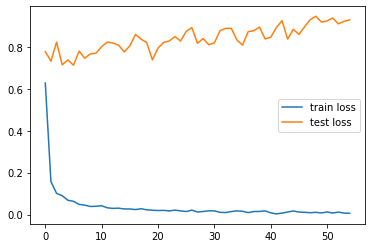

Epoch 5 Train Loss:  0.009343107961043037 Train Accuracy:  0.9969444444444444
Epoch 5 Test Loss:  0.9842723358749944 Test Accuracy:  0.9011111111111111
Epoch 6 Train Loss:  0.008834873851419952 Train Accuracy:  0.9972685185185185
Epoch 6 Test Loss:  0.9376746355202972 Test Accuracy:  0.9024074074074074
Epoch 7 Train Loss:  0.009238838122078893 Train Accuracy:  0.9974074074074074
Epoch 7 Test Loss:  0.9252865558925093 Test Accuracy:  0.9032407407407408
Epoch 8 Train Loss:  0.010229980230058033 Train Accuracy:  0.9973148148148148
Epoch 8 Test Loss:  0.9512557858213074 Test Accuracy:  0.8977777777777778
Epoch 9 Train Loss:  0.005755607304674616 Train Accuracy:  0.9982407407407408
Epoch 9 Test Loss:  1.0060216411416187 Test Accuracy:  0.9006018518518518


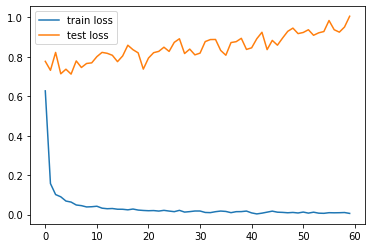

Epoch 10 Train Loss:  0.0074537837968118425 Train Accuracy:  0.9975925925925926
Epoch 10 Test Loss:  0.9696937757680034 Test Accuracy:  0.9008796296296296
Epoch 11 Train Loss:  0.005226970745088861 Train Accuracy:  0.9987037037037036
Epoch 11 Test Loss:  0.9659090069868607 Test Accuracy:  0.9046296296296297
Epoch 12 Train Loss:  0.010682701655511698 Train Accuracy:  0.9968055555555555
Epoch 12 Test Loss:  0.9659832140314393 Test Accuracy:  0.8976388888888889
Epoch 13 Train Loss:  0.008109339153705621 Train Accuracy:  0.997824074074074
Epoch 13 Test Loss:  0.984848445699034 Test Accuracy:  0.8988888888888888
Epoch 14 Train Loss:  0.010193503456787396 Train Accuracy:  0.9975
Epoch 14 Test Loss:  0.9547078005844211 Test Accuracy:  0.8985185185185185


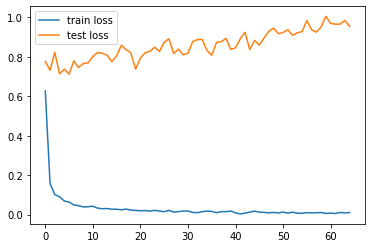

Epoch 15 Train Loss:  0.00532053850415347 Train Accuracy:  0.9982407407407408
Epoch 15 Test Loss:  0.9941754558118602 Test Accuracy:  0.8961574074074075
Epoch 16 Train Loss:  0.006574792818250393 Train Accuracy:  0.9981944444444445
Epoch 16 Test Loss:  0.9600282601957308 Test Accuracy:  0.8993518518518518
Epoch 17 Train Loss:  0.004047411773107914 Train Accuracy:  0.9988888888888889
Epoch 17 Test Loss:  0.9815128619872148 Test Accuracy:  0.9046296296296297
Epoch 18 Train Loss:  0.007945675684670143 Train Accuracy:  0.9978703703703704
Epoch 18 Test Loss:  0.9833666591549513 Test Accuracy:  0.8992129629629629
Epoch 19 Train Loss:  0.013829578368512794 Train Accuracy:  0.9964351851851851
Epoch 19 Test Loss:  0.9973030318468973 Test Accuracy:  0.8955555555555555


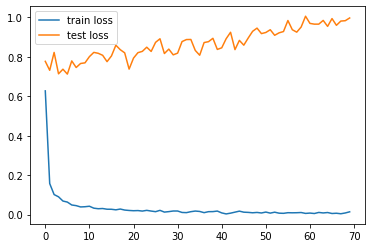

In [ ]:
for epoch in range(n_epochs):
    losses,accs = [],[]
    for i,(x,y) in enumerate(dload_train):
        x,y = x.to(device),y.to(device)
        L = 0.
        logits = f(x)
        loss = nn.CrossEntropyLoss()(logits,y)
        acc = (logits.max(1)[1] == y).float().mean()
        losses.append(loss.item())
        accs.append(acc.item())
        L += loss
        optim.zero_grad()
        L.backward()
        optim.step()
    train_loss = np.mean(losses)
    train_acc = np.mean(accs)
    test_loss, test_acc = evaluate(f,dload_test,device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    if test_acc > best_acc:
        t.save(f.state_dict(), "/content/drive/MyDrive/CS480/Final/imgf3.pt")
    print("Epoch", epoch, "Train Loss: ", train_loss, "Train Accuracy: ", train_acc)
    print("Epoch", epoch, "Test Loss: ", test_loss, "Test Accuracy: ", test_acc)
    if epoch%5==4:
        plt.plot(train_loss_history,label="train loss")
        plt.plot(test_loss_history,label="test loss")
        plt.legend()
        plt.show()

# Submit resnet

In [ ]:
fn = tr.Compose([tr.Resize(im_sz),tr.CenterCrop(im_sz),tr.ToTensor()])
Categories = ['Accessories', 'Apparel Set', 'Bags', 'Belts', 'Bottomwear', 'Cufflinks', 'Dress', 'Eyewear', 'Flip Flops', 'Fragrance', 'Free Gifts', 'Headwear', 'Innerwear', 'Jewellery', 'Lips', 'Loungewear and Nightwear', 'Makeup', 'Nails', 'Sandal', 'Saree', 'Scarves', 'Shoes', 'Socks', 'Ties', 'Topwear', 'Wallets', 'Watches']
def image_loader(image_name):
    image = Image.open(image_name)
    image = fn(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

def predict(f,path,device):
    im = image_loader(path)
    im.to(device)
    logits = f(im)
    category = Categories[logits.max(1)[1][0].item()]
    return category


In [ ]:
def get_preds(f,path,device):
    f.eval()
    preds = []
    for i,im in enumerate(os.listdir(path)):
        im_path = os.path.join(path,im)
        id = im.strip(".jpg")
        category = predict(f,im_path,device)
        preds.append([id,category])
        if i%1000==0: print(i)
    f.train()
    return preds

In [ ]:
preds = get_preds(f,"/content/drive/MyDrive/CS480/Final/test/",device)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000


In [ ]:
with open("/content/drive/MyDrive/CS480/Final/model1.csv","w") as csvFile:
    print("id,category",file=csvFile)
    for id,cat in preds:
        print(id+","+cat,file=csvFile)

# Sentence Encoder

In [ ]:
#https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder
%%capture
!pip3 install seaborn

In [ ]:
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


# All Encoders

In [ ]:
def encode_features(row):
    g = np.zeros(len(genders_dict))
    b = np.zeros(len(baseColours_dict))
    s = np.zeros(len(seasons_dict))
    u = np.zeros(len(usages_dict))
    g[genders_dict[row['gender']]] = 1
    b[baseColours_dict[row['baseColour']]] = 1
    s[seasons_dict[row['season']]] = 1
    u[usages_dict[row['usage']]] = 1
    enc = np.concatenate((g,b,s,u))
    return enc

In [ ]:
def image_loader(image_name):
    fn = tr.Compose([tr.Resize(im_sz),tr.CenterCrop(im_sz),tr.ToTensor()])
    image = Image.open(image_name)
    image = fn(image).float()
    image = Variable(image, requires_grad=False)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image#.cuda()  #assumes that you're using GPU

def load_img_encoder():
    encoder = F('resnet18',n_classes)
    encoder.load_state_dict(t.load("/content/drive/MyDrive/CS480/Final/imgf3.pt",map_location=t.device('cpu')))
    encoder.model.fc = nn.Linear(encoder.num_ftrs,512)
    encoder.eval()
    return encoder

encoder = load_img_encoder()
def encode_image(row):
    path = '/content/drive/MyDrive/CS480/Final/shuffled-images/'+str(row['id'])+'.jpg'
    #path = '/content/drive/MyDrive/CS480/Final/test/60000.jpg'
    im = image_loader(path)
    #im.to(device)
    enc = encoder(im).detach().numpy()
    return enc[0]

In [ ]:
def encode_sentence(row):
    sent = [row['noisyTextDescription']]
    enc = embed(sent).numpy()[0]
    return enc

In [ ]:
def get_data(path,train=True):
    file = open(path,'r')
    df = pd.read_csv(file)
    x = []
    if train: y = []
    for i, row in df.iterrows():
        enc1 = encode_image(row)
        enc2 = encode_features(row)
        enc3 = encode_sentence(row)
        enc = np.concatenate((enc1,enc2,enc3))
        x.append(enc)
        if train: y.append(categories_dict[row['category']])
        if i%1000==0: print(i)
    if train:
        x,y = t.tensor(x),t.tensor(y,dtype=t.long)
        return x,y
    else:
        x = t.tensor(x)
        return x

In [ ]:
train_x_no_image,train_y_no_image = get_data('/content/drive/MyDrive/CS480/Final/train.csv')

In [ ]:
np.save('/content/drive/MyDrive/CS480/Final/train_x',train_x.numpy())
np.save('/content/drive/MyDrive/CS480/Final/train_y',train_y.numpy())
np.save('/content/drive/MyDrive/CS480/Final/test_x',test_x.numpy())

# Stacked MLP with Cross Validation Training

In [ ]:
X = np.load('/content/drive/MyDrive/CS480/Final/train_x.npy')
y = np.load('/content/drive/MyDrive/CS480/Final/train_y.npy')

In [ ]:
mlp1 = pickle.load(open('/content/drive/MyDrive/CS480/mlp1.sav', 'rb'))
mlp2 = pickle.load(open('/content/drive/MyDrive/CS480/mlp2.sav', 'rb'))
mlp3 = pickle.load(open('/content/drive/MyDrive/CS480/mlp3.sav', 'rb'))
lg = pickle.load(open('/content/drive/MyDrive/CS480/lg.sav', 'rb'))

In [ ]:
x_train,y_train,x_test,y_test = train_test_split(X,y,test_size=0.20)
kfolds = 3
ntrain = x_train.shape[0]
ntest = x_test.shape[0]

class MLP(object):
    def __init__(self):
        self.f = MLPClassifier(hidden_layer_sizes=(512,512),early_stopping=True,verbose=False,max_iter=1)
    def train(self, x_train, y_train):
        self.f.fit(x_train,y_train)
    def predict(self, x):
        return self.f.predict_proba(x)

def trainclf(clf):
    oof_train = np.zeros((len(x_train),n_classes))
    oof_test = np.zeros((kfolds, len(x_test),n_classes)) # test pred per fold
    kf = KFold(n_splits = kfolds, shuffle=False)
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        x_tr = X[train_index]
        y_tr = y[train_index]
        x_te = X[test_index]
        y_te = y[test_index]
        
        clf.train(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test[i, :] = clf.predict(x_test)
    oof_test = oof_test.mean(axis=0)
    return oof_train, oof_test

In [ ]:
m1 = MLP()
m2 = MLP()
m3 = MLP()
tr1, te1 = trainclf(m1)
tr2, te2 = trainclf(m2)
tr3, te3 = trainclf(m3)

In [ ]:
x_tr_lg = np.concatenate((tr1, tr2, tr3), axis=1)
x_te_lg = np.concatenate((te1, te2, te3), axis=1)

In [ ]:
lg = LogisticRegression()
lg.fit(x_tr_lg,y_train)

In [ ]:
ypred = lg.predict(x_te_lg)
p = [round(v) for v in ypred]
accuracy = accuracy_score(y_test, p)
accuracy

0.9292583687812096

In [ ]:
Categories = ['Accessories', 'Apparel Set', 'Bags', 'Belts', 'Bottomwear', 'Cufflinks', 'Dress', 'Eyewear', 'Flip Flops', 'Fragrance', 'Free Gifts', 'Headwear', 'Innerwear', 'Jewellery', 'Lips', 'Loungewear and Nightwear', 'Makeup', 'Nails', 'Sandal', 'Saree', 'Scarves', 'Shoes', 'Socks', 'Ties', 'Topwear', 'Wallets', 'Watches']
def get_preds(path,x_test):
    file = open(path,'r')
    df = pd.read_csv(file)
    preds = []
    for i, row in df.iterrows():
        id = row['id']
        enc = [x_test[i]]
        e1 = mlp1.predict(enc)
        e2 = mlp2.predict(enc)
        e3 = mlp3.predict(enc)
        enc = np.concatenate((e1,e2,e3),axis=1)
        pred = lg.predict(enc)[0]
        cat = Categories[pred]
        preds.append([id,cat])
        if i%1000==0: print(i)
    return preds

In [ ]:
test_path = '/content/drive/MyDrive/CS480/Final/test.csv'
test_data = np.load('/content/drive/MyDrive/CS480/Final/test_x.npy')
p = get_preds(test_path,test_data)

In [ ]:
with open("/content/drive/MyDrive/CS480/MLP3.csv","w") as csvFile:
    print("id,category",file=csvFile)
    for id,cat in p:
        print(str(id)+","+cat,file=csvFile)

# 1 MLP

In [ ]:
class MLP(object):
    def __init__(self):
        self.f = MLPClassifier(hidden_layer_sizes=(512),early_stopping=True,verbose=False)
    def train(self, x_train, y_train):
        self.f.fit(x_train,y_train)
    def predict(self, x):
        return self.f.predict(x)

x_train,y_train,x_test,y_test = train_test_split(X,y,test_size=0.20)
mlp = MLP()
mlp.train(x_train,y_train)
preds = mlp.predict(x_test)
preds = [round(v) for v in preds]
accuracy = accuracy_score(y_test, preds)
accuracy

In [ ]:
Categories = ['Accessories', 'Apparel Set', 'Bags', 'Belts', 'Bottomwear', 'Cufflinks', 'Dress', 'Eyewear', 'Flip Flops', 'Fragrance', 'Free Gifts', 'Headwear', 'Innerwear', 'Jewellery', 'Lips', 'Loungewear and Nightwear', 'Makeup', 'Nails', 'Sandal', 'Saree', 'Scarves', 'Shoes', 'Socks', 'Ties', 'Topwear', 'Wallets', 'Watches']
def get_preds(path,x_test):
    file = open(path,'r')
    df = pd.read_csv(file)
    preds = []
    for i, row in df.iterrows():
        id = row['id']
        enc = [x_test[i]]
        pred = mymlp.predict(enc)[0]
        cat = Categories[pred]
        preds.append(pred)
        if i%1000==0: print(i)
    return preds

In [ ]:
test_x = np.load('/content/drive/MyDrive/CS480/test_x.npy')
test_path = '/content/drive/MyDrive/CS480/test.csv'
p = get_preds(test_path,test_x)

In [ ]:
with open("/content/drive/MyDrive/CS480/MLP4_1.csv","w") as csvFile:
    print("id,category",file=csvFile)
    for id,cat in p:
        print(str(id)+","+cat,file=csvFile)